In [2]:
from ensembles_ import *
from metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Import Data

In [3]:
data = pd.read_csv('kc_house_data.csv')

data.shape

(21613, 21)

# Preprocessing

In [4]:
data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [5]:
data['year_of_sale'] = pd.to_datetime(data['date']).dt.year
data['month_of_sale'] = pd.to_datetime(data['date']).dt.month

In [6]:
# target = np.log1p(data['price'])
target = data['price']
data.drop(['id', 'price', 'date'], inplace=True, errors='ignore', axis=1)
# zipcode ?????????????????????

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.values, target.values, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16209, 20), (5404, 20), (16209,), (5404,))

# Expirements

## Random Forest

In [101]:
df_n_est = pd.DataFrame()

for n_est in [10000]:
    model = RandomForestMSE(n_estimators=n_est, max_depth=None, feature_subsample_size=0.6)
    history = model.fit(X_train, y_train, X_test, y_test)
    history['n_est'] = [n_est] * len(history['time'])
    history['x'] = list(range(len(history['time'])))
    df_n_est = df_n_est.append(pd.DataFrame(history), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:59<00:00, 11.91it/s]


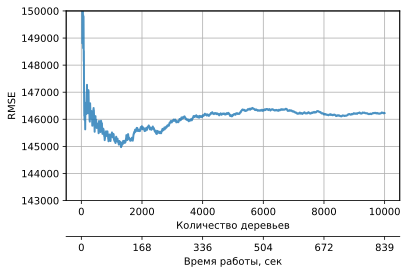

In [111]:
plt.figure(figsize=(6, 3.5))
ax = sns.lineplot(data=df_n_est, x='x', y='val_score', linewidth=2, alpha=0.8, palette='tab10')
plt.grid()
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')
plt.ylim(143_000, 150_000)

ax2 = ax.twiny()
        
ax2.set_xticks(ax.get_xticks())
ax2.set_xbound(ax.get_xbound())
x_add_lab = ax.get_xticks() * np.mean(np.diff(df_n_est['time']))
x_add_lab = [f'{x:.0f}' for x in x_add_lab]
ax2.set_xticklabels(x_add_lab)

ax2.set_xlabel('Время работы, сек')

ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))

plt.savefig('plots/rf_n_est.svg')

In [112]:
df_sub_size = pd.DataFrame()

for sub_size in [0.2, 0.4, 0.6, 0.8, 1]:
    model = RandomForestMSE(n_estimators=1200, max_depth=None, feature_subsample_size=sub_size)
    history = model.fit(X_train, y_train, X_test, y_test)
    history['sub_size'] = [sub_size] * len(history['time'])
    history['x'] = list(range(len(history['time'])))
    df_sub_size = df_sub_size.append(pd.DataFrame(history), ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:42<00:00, 28.13it/s]


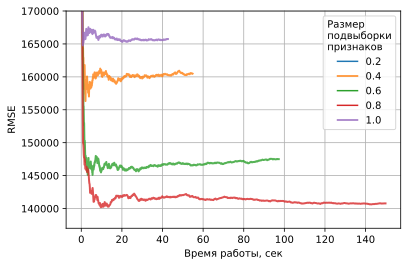

In [116]:
sns.lineplot(data=df_sub_size, x='time', y='val_score', hue='sub_size', linewidth=2, alpha=0.8, palette='tab10')
plt.grid()
plt.ylim(137_000, 170_000)
plt.legend(title="Размер\nподвыборки\nпризнаков", loc='upper right')
plt.xlabel('Время работы, сек')
plt.ylabel('RMSE')

plt.savefig('plots/rf_subsize.svg')

In [117]:
df_depth = pd.DataFrame()

for depth in [10, 20, 30, 40, None]:
    model = RandomForestMSE(n_estimators=1000, max_depth=depth, feature_subsample_size=0.8)
    history = model.fit(X_train, y_train, X_test, y_test)
    history['depth'] = [str(depth)] * len(history['time'])
    history['x'] = list(range(len(history['time'])))
    df_depth = df_depth.append(pd.DataFrame(history), ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.16it/s]


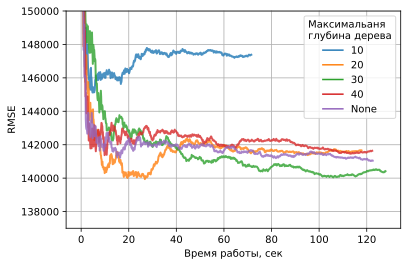

In [155]:
# plt.figure(figsize=(4, 3))

sns.lineplot(data=df_depth, x='time', y='val_score', hue='depth', linewidth=2, alpha=0.8, palette='tab10')
plt.grid()
plt.ylim(137_000, 150_000)
plt.legend(title="Максимальаня\nглубина дерева", loc='upper right')
plt.xlabel('Время работы, сек')
plt.ylabel('RMSE')

plt.savefig('plots/rf_depth.svg')

In [8]:
model = RandomForestMSE(n_estimators=1000, max_depth=30, feature_subsample_size=0.8)
model.fit(X_train, y_train)

# pred = model.predict(X_test)
print("Final RMSE: Train = ", RMSE(model.predict(X_test), y_test), 
     '; Test = ', RMSE(model.predict(X_train), y_train))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.01it/s]


Final RMSE: Train =  140420.95668230238 ; Test =  45603.54382230199


## Gradient Boosting

In [120]:
df_n_est_ = pd.DataFrame()

for n_est in [10000]:
    model = GradientBoostingMSE(n_estimators=n_est, max_depth=5,
                                feature_subsample_size=0.8, learning_rate=0.1)
    history = model.fit(X_train, y_train, X_test, y_test)
    history['n_est'] = [n_est] * len(history['time'])
    history['x'] = list(range(len(history['time'])))
    df_n_est_ = df_n_est_.append(pd.DataFrame(history), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:17<00:00, 20.09it/s]


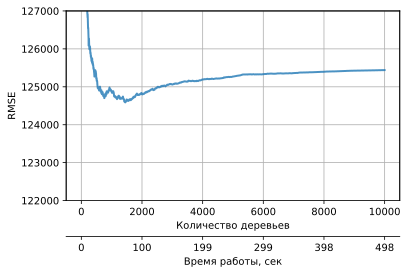

In [152]:
plt.figure(figsize=(6, 3.5))
ax = sns.lineplot(data=df_n_est_, x='x', y='val_score', linewidth=2, alpha=0.8, palette='tab10')
plt.grid()
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')
plt.ylim(122_000, 127_000)
ax2 = ax.twiny()
        
ax2.set_xticks(ax.get_xticks())
ax2.set_xbound(ax.get_xbound())
x_add_lab = ax.get_xticks() * np.mean(np.diff(df_n_est_['time']))
x_add_lab = [f'{x:.0f}' for x in x_add_lab]
ax2.set_xticklabels(x_add_lab)

ax2.set_xlabel('Время работы, сек')

ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))

plt.savefig('plots/gb_n_est.svg')

In [124]:
df_sub_size_ = pd.DataFrame()

for sub_size in [0.2, 0.4, 0.6, 0.8, 1]:
    model = GradientBoostingMSE(n_estimators=1000, max_depth=5,
                            feature_subsample_size=sub_size, 
                            learning_rate=0.1)
    history = model.fit(X_train, y_train, X_test, y_test)
    history['sub_size'] = [sub_size] * len(history['time'])
    history['x'] = list(range(len(history['time'])))
    df_sub_size_ = df_sub_size_.append(pd.DataFrame(history), ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.96it/s]


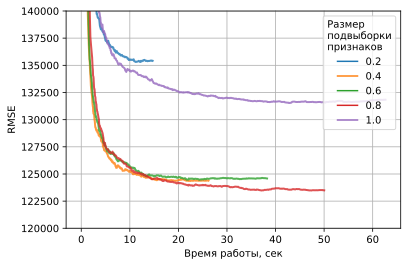

In [147]:
sns.lineplot(data=df_sub_size_, x='time', y='val_score', hue='sub_size', linewidth=2, alpha=0.8, palette='tab10')
plt.grid()
plt.ylim(120_000, 140_000)
plt.legend(title="Размер\nподвыборки\nпризнаков", loc='upper right')
plt.xlabel('Время работы, сек')
plt.ylabel('RMSE')

plt.savefig('plots/gb_subsize.svg')

In [156]:
df_depth_ = pd.DataFrame()

for depth in [3, 4, 5, 6, 7, None]:
    model = GradientBoostingMSE(n_estimators=1000, max_depth=depth,
                                feature_subsample_size=0.8,
                               learning_rate=0.1)
    history = model.fit(X_train, y_train, X_test, y_test)
    history['depth'] = [str(depth)] * len(history['time'])
    history['x'] = list(range(len(history['time'])))
    df_depth_ = df_depth_.append(pd.DataFrame(history), ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:37<00:00,  6.36it/s]


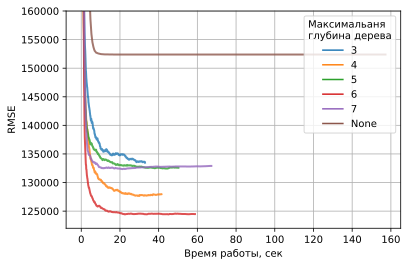

In [159]:
# plt.figure(figsize=(4, 3))

sns.lineplot(data=df_depth_, x='time', y='val_score', hue='depth', linewidth=2, alpha=0.8, palette='tab10')
plt.grid()
plt.ylim(122_000, 160_000)
plt.legend(title="Максимальаня\nглубина дерева", loc='upper right')
plt.xlabel('Время работы, сек')
plt.ylabel('RMSE')

plt.savefig('plots/gb_depth.svg')

In [160]:
df_learning_ = pd.DataFrame()

for learning in [0.5, 0.1, 0.15, 0.2, 0.3]:
    model = GradientBoostingMSE(n_estimators=1000, max_depth=6,
                                feature_subsample_size=0.8, learning_rate=learning)
    history = model.fit(X_train, y_train, X_test, y_test)
    history['learning'] = [str(learning)] * len(history['time'])
    history['x'] = list(range(len(history['time'])))
    df_learning_ = df_learning_.append(pd.DataFrame(history), ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.95it/s]


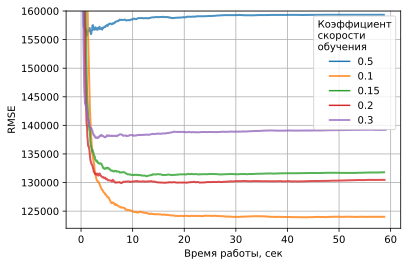

In [162]:
# plt.figure(figsize=(4, 3))

sns.lineplot(data=df_learning_, x='time', y='val_score', hue='learning', linewidth=2, alpha=0.8, palette='tab10')
plt.grid()
plt.ylim(122_000, 160_000)
plt.legend(title="Коэффициент\nскорости\nобучения", loc='upper right')
plt.xlabel('Время работы, сек')
plt.ylabel('RMSE')

plt.savefig('plots/gb_learning.svg')

In [9]:
model = GradientBoostingMSE(n_estimators=1000, max_depth=6,
                        feature_subsample_size=0.8, learning_rate=0.1)
model.fit(X_train, y_train)

print("Final RMSE: Test ", RMSE(model.predict(X_test), y_test),
     " Train ", RMSE(model.predict(X_train), y_train))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.29it/s]


Final RMSE: Test  128962.51429719209  Train  24767.515993063345


<AxesSubplot:>

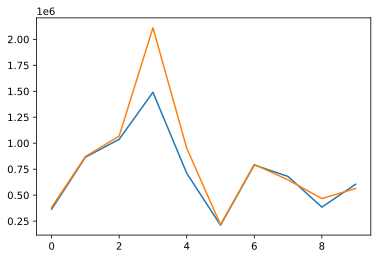

In [164]:
sns.lineplot(x=np.arange(10), y=y_test[:10])
sns.lineplot(x=np.arange(10), y=pred[:10])